# Figure 6. Exploratory analysis on PBMC dataset

The code for creating Supplementary Table 1, Supplementary Figure 2, and Supplementary Figure 3 is also provided here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from dendrosplit import split,merge,utils
from dendrosplit_pipeline import *
sys.setrecursionlimit(5000)
%matplotlib inline

In [2]:
import os,pickle,h5py
from sklearn.metrics import adjusted_rand_score

datadir = '../data/'

def save_mat_h5f(X,flname):
    h5f = h5py.File(flname, 'w')
    h5f.create_dataset('dataset_1', data=X)
    h5f.close()
    
def load_mat_h5f(flname):
    h5f = h5py.File(flname,'r')
    X = h5f['dataset_1'][:]
    h5f.close()
    return X

# Analysis
def generate_and_save_distmat(X,save_name,recompute=False,standardize=False):
    if os.path.isfile(save_name) and recompute is False:
        print('distances precomputed. loading..')
        D = load_mat_h5f(save_name)
    else:
        D = generate_log_corr_D(X,standardize=standardize)
        save_mat_h5f(D,save_name)
    return D

def analyze_dataset(X,genes,dataset,D=None,sthresh=30,mthresh=10,verbose=True,
                    disband_percentile=50,recompute_dist=False):
    start_analysis = time.time()
    X,genes = split.filter_genes(X,genes,0) # Remove genes with 0 counts
    if D is None:
        D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation.pickle'%(datadir,dataset,dataset),
                                      recompute=recompute_dist) # Compute distance matrix
    ys,shistory,ym,mhistory = get_clusters(D,X,sthresh=sthresh,mthresh=mthresh,
                                           verbose=verbose,dp=disband_percentile) # Get clusters
    print('analysis done (%.2f s elapsed)'%(time.time()-start_analysis))
    return X,genes,D,ys,shistory,ym,mhistory

def three_plots(x1,x2,Y,ys,ym,legend_pos=(1.5,1),markersize=5,select_inds=None):
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    split.plot_labels_legend(x1,x2,Y,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('True labels')
    plt.subplot(1,3,2)
    split.plot_labels_legend(x1,x2,ys,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('Labels after split')
    plt.subplot(1,3,3)
    split.plot_labels_legend(x1,x2,ym,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('Labels after merge')

### Performance on cell and gene-filtered dataset

In [3]:
%%time
dataset = 'Zheng'

X = load_mat_h5f('%s%s/%s_expr.h5'%(datadir,dataset,dataset))
Y = np.loadtxt('%s%s/%s_labels.txt'%(datadir,dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
genes = np.loadtxt('%s%s/%s_features.txt'%(datadir,dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
print(np.shape(X))

# Remove all genes that have 0 molecules in total over all cells
X,genes = split.filter_genes(X,genes,0)

# DropSeq approach to gene selection
keep_inds = split.dropseq_gene_selection(np.log(1+X),z_cutoff=1.0,bins=5)
X,genes = X[:,keep_inds],genes[keep_inds]
print('Kept %s features after DropSeq gene selection step.'%(len(X[0])))

# Filter out cells that don't have at least 50 counts across all cells
inds = np.sum(X,1) >= 50
inds_removed = np.logical_not(inds)
X,X_removed = X[inds],X[inds_removed]
Y,Y_removed = Y[inds],Y[inds_removed]
print('Kept %s cells for having at least 50 counts across all genes.'%(len(X)))

# And again, remove all genes that have 0 molecules in total over all cells
X,genes = split.filter_genes(X,genes,0)

# Load previously computed tsne coordinates
xtsne = np.loadtxt('%sZheng/Zheng_reducedim_coor_%scells.txt'%(datadir,len(X)))
x1,x2 = xtsne[:,0],xtsne[:,1]

# Remove ENSEMBL part of each gene name
genes = np.array([i.split()[1] for i in genes])

(68579, 20374)
Kept 20374 features for having > 0 counts across all cells
Kept 1016 features after DropSeq gene selection step.
Kept 17426 cells for having at least 50 counts across all genes.
Kept 908 features for having > 0 counts across all cells
CPU times: user 1min 8s, sys: 39.3 s, total: 1min 47s
Wall time: 1min 48s


In [4]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 200
mthresh = 100
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 33.188 s.
Kept 908 features for having > 0 counts across all cells
Potential split result: 233 and 17193
 Split score 1.8E+308
Potential split result: 200 and 33
 Split score 144.53
Potential split result: 9395 and 7798
 Split score 1.8E+308
Potential split result: 8168 and 1227
 Split score 1.8E+308
Potential split result: 7678 and 490
 Split score 201.55
Potential split result: 3189 and 4489
 Split score 1.8E+308
Potential split result: 1135 and 2054
 Split score 253.87
Potential split result: 37 and 1098
 Split score 21.91
Potential split result: 516 and 1538
 Split score 253.54
Potential split result: 130 and 386
 Split score 44.34
Potential split result: 94 and 1444
 Split score 12.90
Potential split result: 26 and 4463
 Split score 1.8E+308
Potential split result: 16 and 10
 Split score 3.57
Potential split result: 11 and 4452
 Split score 144.74
Potential split result: 286 and 204
 Split score 79.40
Potential split result: 140 and 1087
 Split score 13

Adjusted rand score (ys): 0.51
Adjusted rand score (ym): 0.54


../dendrosplit/utils.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if -1 in labels or '-1' in labels: Ncolors -= 1


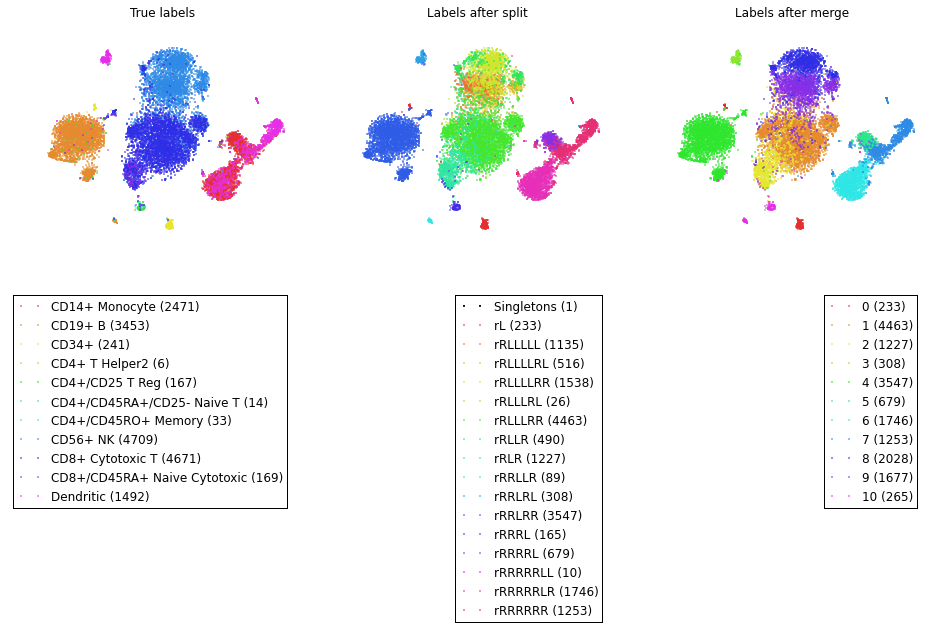

In [5]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
three_plots(x1,x2,Y,ys,ym,markersize=2,legend_pos=(1,-0.2))

/home/jessez/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


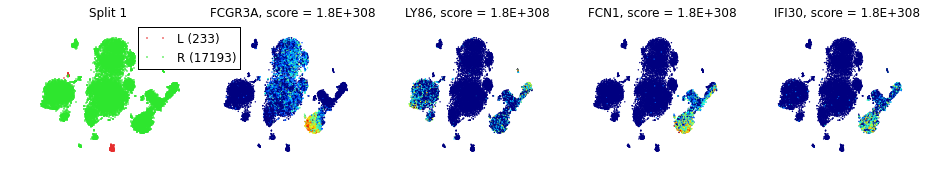

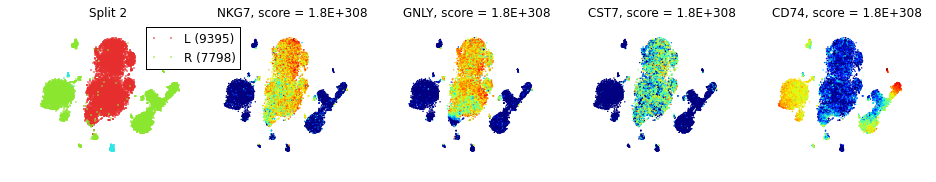

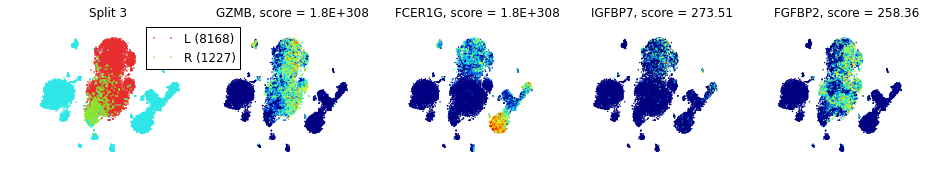

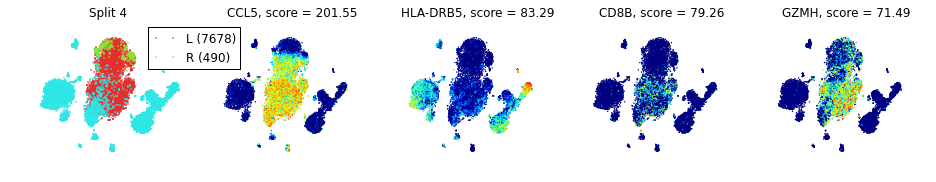

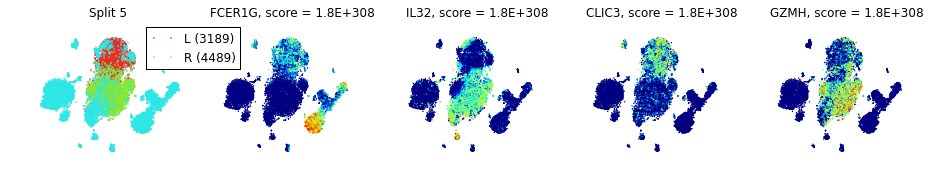

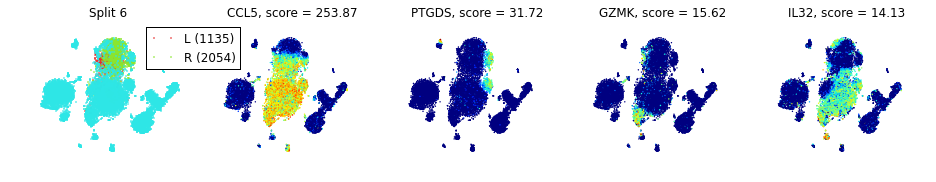

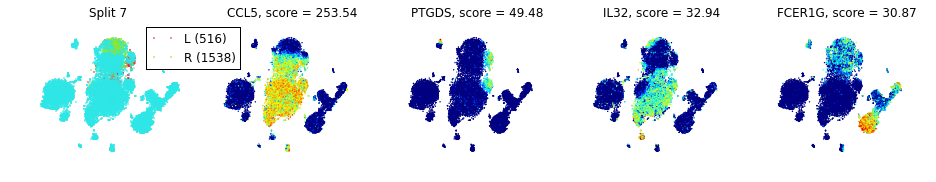

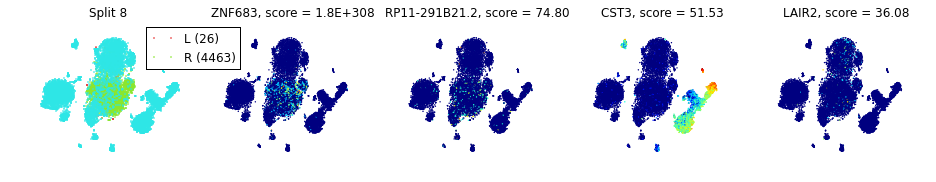

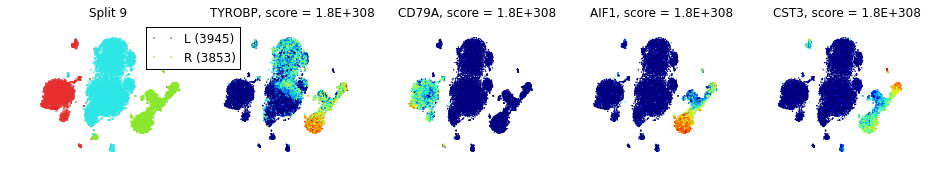

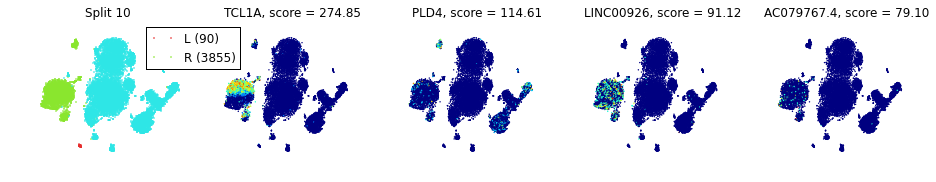

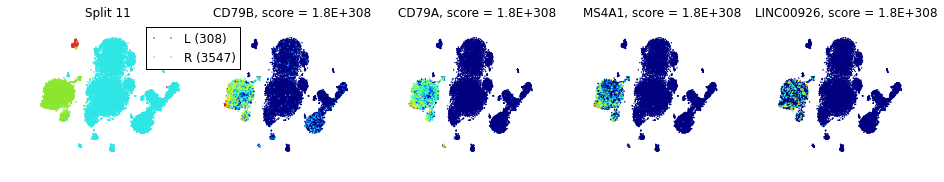

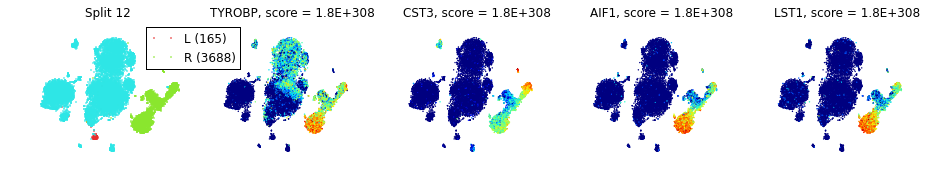

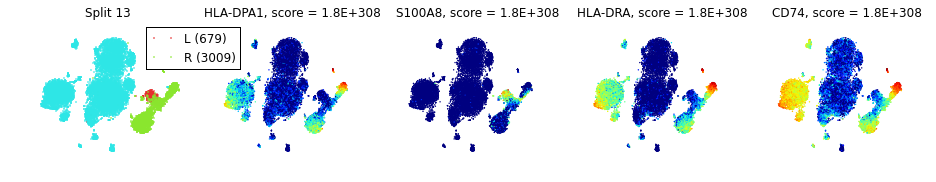

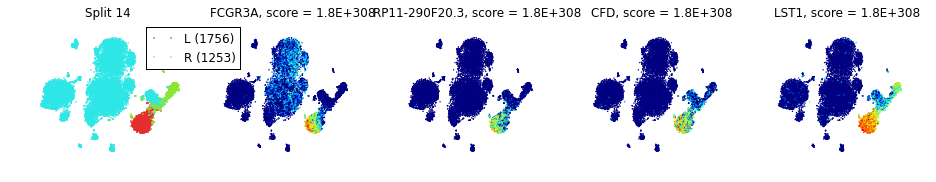

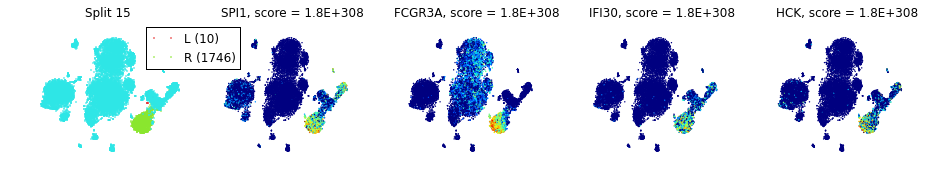

In [6]:
# Look at top few genes for each split
num_genes = 4
ii = 0
for i in shistory:
    if len(i) < 8: continue
    plt.figure(figsize=(16,2.5))
    plt.subplot(1,num_genes+1,1)
    split.plot_labels_legend(x1,x2,i[1],markersize=2)
    plt.title('Split %s'%(ii+1))
    for j in range(num_genes):
        plt.subplot(1,num_genes+1,j+2)
        expr = np.log(1+X[:,i[4][j]])
        plt.scatter(x1,x2,edgecolors='none',c=expr,s=2)
        plt.title('%s, score = %s'
                  %(genes[i[4][j]],split.sn(i[5][j])))
        plt.axis('off')
    ii += 1

In [7]:
# Identify distinguishing genes (Supplementary Table 1)
split.save_more_highly_expressed_genes_in_one_clust(X,genes,ym,x1,x2,num_genes=20,
                                                    show_plots=False,verbose=False,
                                                    save_name='%sZheng/Zheng'%(datadir))

### Performance on full dataset

Supplementary Figure 3

In [8]:
%%time

X = load_mat_h5f('%s%s/%s_expr.h5'%(datadir,dataset,dataset))
Y = np.loadtxt('%s%s/%s_labels.txt'%(datadir,dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
genes = np.loadtxt('%s%s/%s_features.txt'%(datadir,dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
print(np.shape(X))

# Remove ENSEMBL part of each gene name
genes = np.array([i.split()[1] for i in genes])

# Load previously computed tsne coordinates
xtsne = np.loadtxt('%sZheng/Zheng_reducedim_coor_%scells.txt'%(datadir,len(X)))
x1,x2 = xtsne[:,0],xtsne[:,1]

(68579, 20374)
CPU times: user 1.36 s, sys: 7.1 s, total: 8.46 s
Wall time: 8.46 s


In [9]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 400
mthresh = 200
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 2366.498 s.
Kept 20374 features for having > 0 counts across all cells
Potential split result: 163 and 68416
 Split score 1.8E+308
Potential split result: 48 and 115
 Split score 15.97
Potential split result: 6 and 68410
 Split score 1.8E+308
Potential split result: 3 and 3
 Split score 1.81
Disbanding (points in cluster too far from each other)
Potential split result: 8 and 68402
 Split score 1.8E+308
Potential split result: 1 and 7
Potential split result: 1 and 6
Potential split result: 1 and 5
Potential split result: 1 and 4
Potential split result: 1 and 3
Potential split result: 1 and 2
Potential split result: 1 and 1
Disbanding (points in cluster too far from each other)
Potential split result: 50260 and 18142
 Split score 1.8E+308
Potential split result: 4112 and 46148
 Split score 1.8E+308
Potential split result: 9 and 4103
 Split score 1.8E+308
Potential split result: 4 and 5
 Split score 1.91
Disbanding (points in cluster too far from each other)
Po

Adjusted rand score (ys): 0.32
Adjusted rand score (ym): 0.32


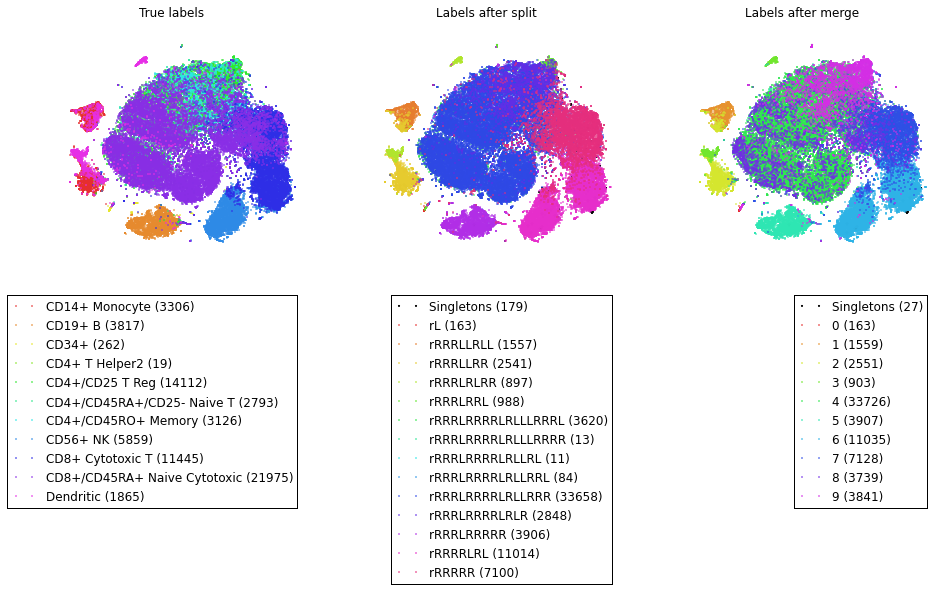

In [10]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
three_plots(x1,x2,Y,ys,ym,markersize=2,legend_pos=(1,-0.2))

ERROR! Session/line number was not unique in database. History logging moved to new session 892


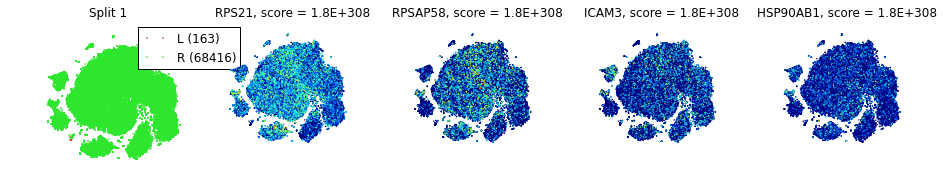

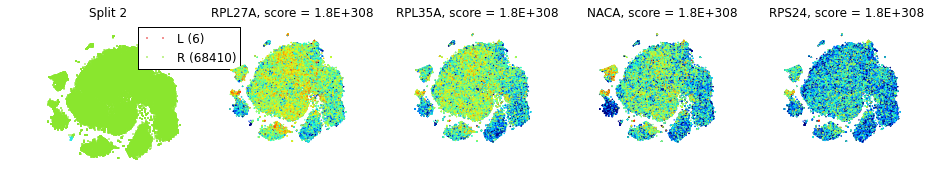

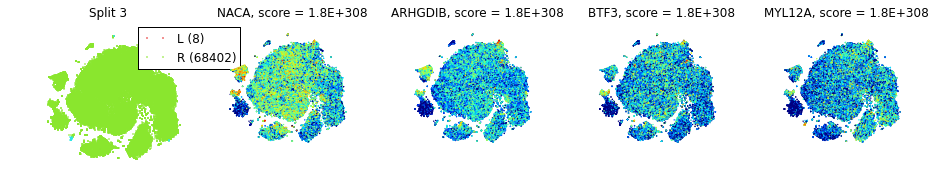

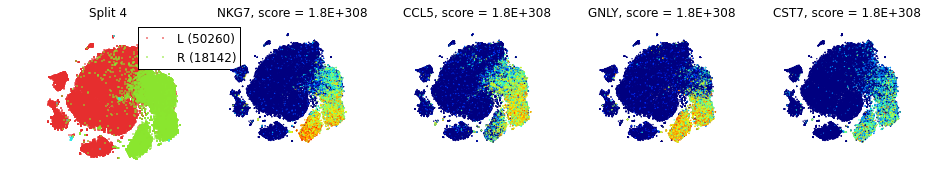

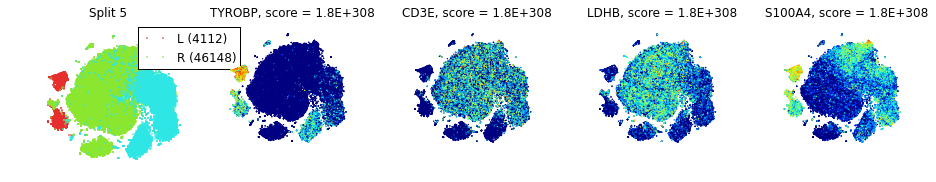

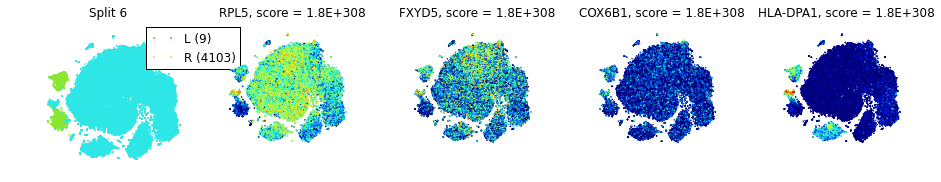

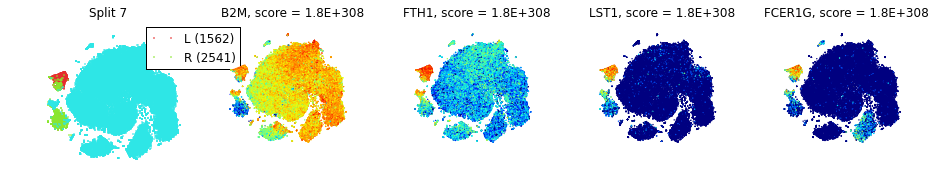

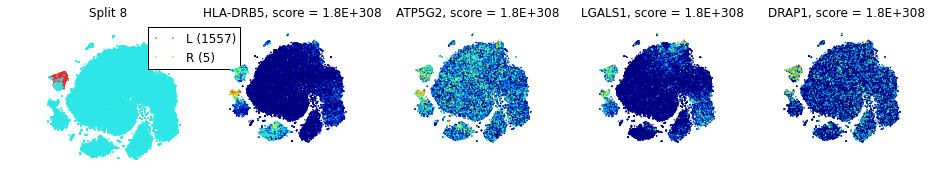

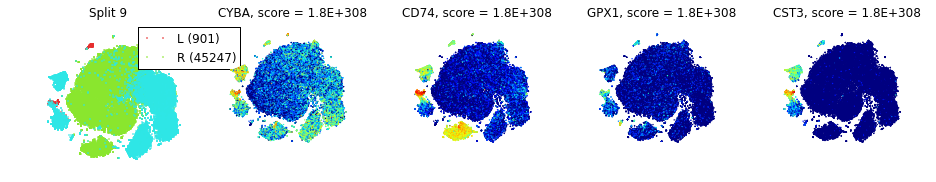

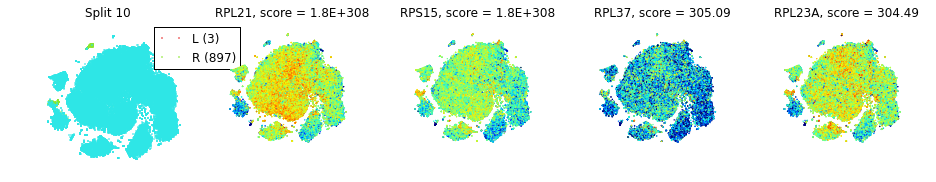

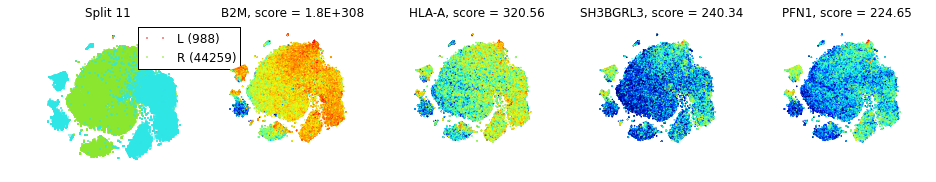

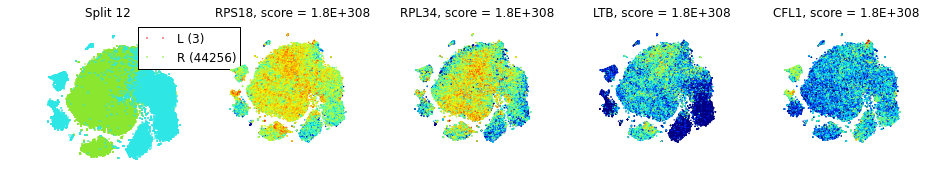

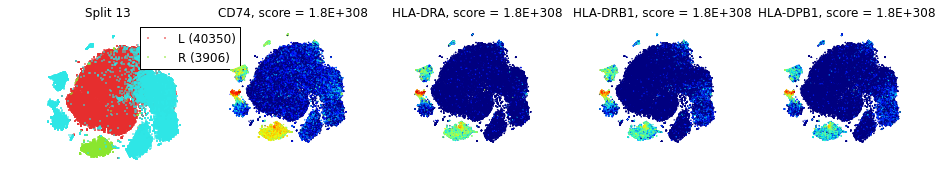

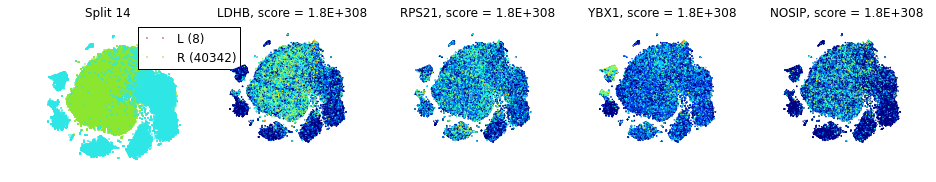

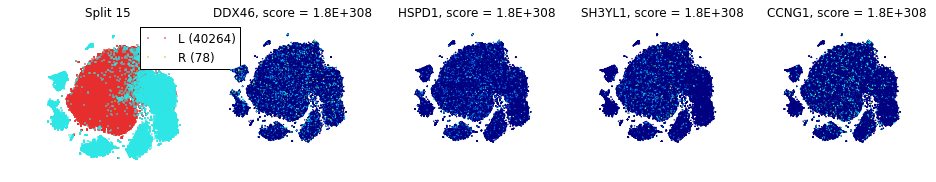

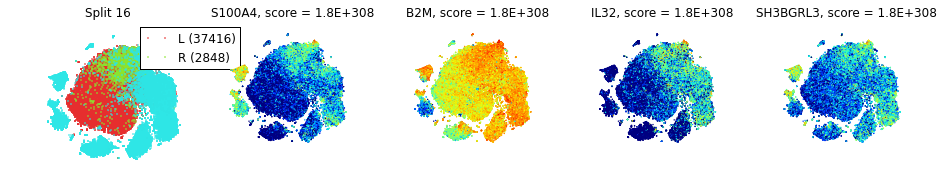

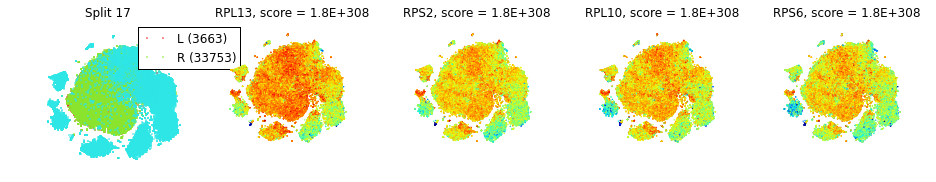

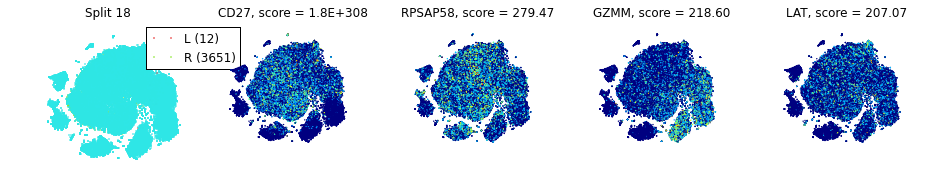

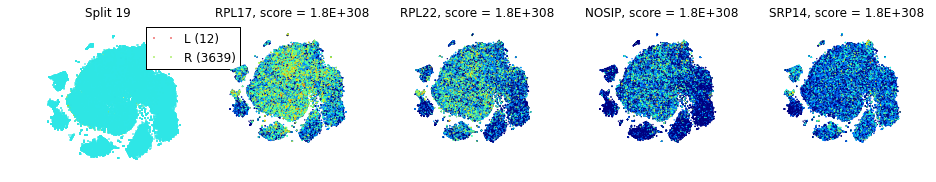

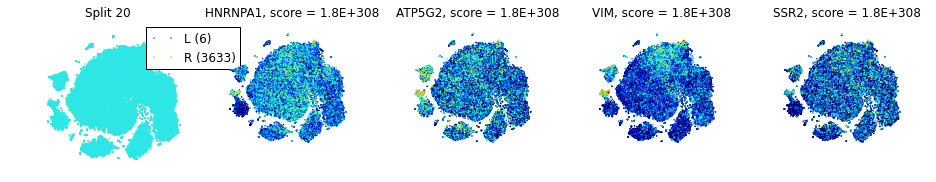

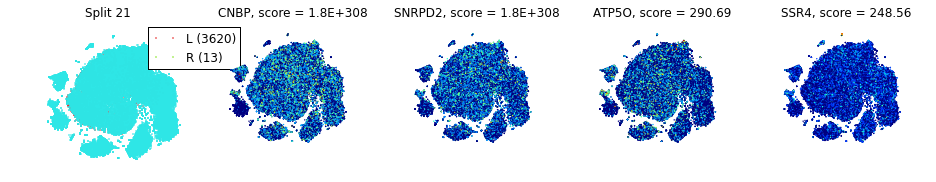

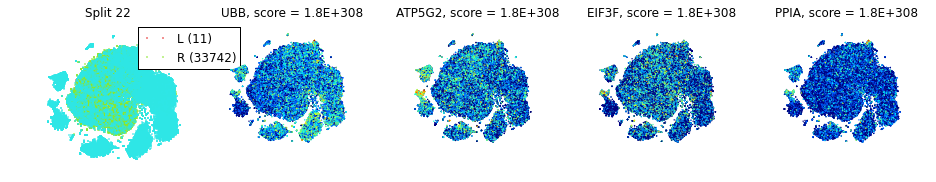

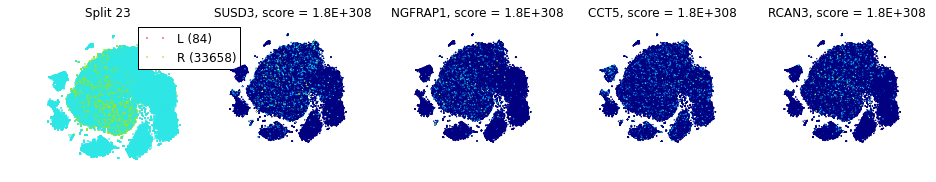

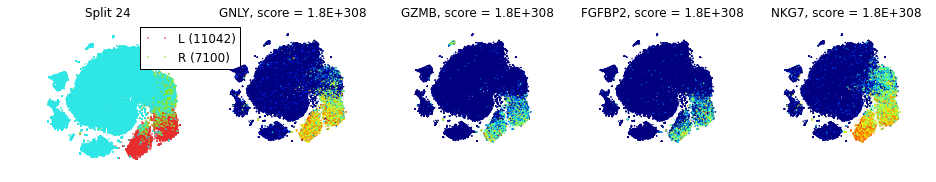

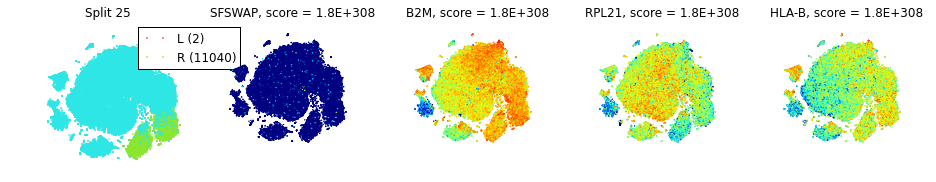

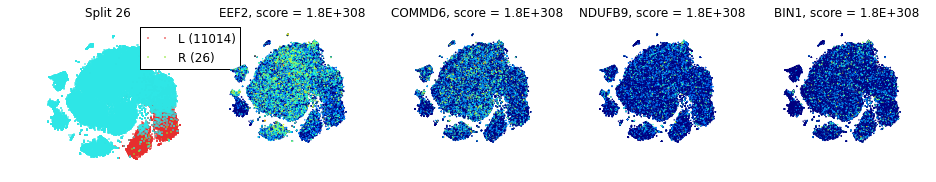

In [11]:
# Look at top few genes for each split
num_genes = 4
ii = 0
for i in shistory:
    if len(i) < 8: continue
    plt.figure(figsize=(16,2.5))
    plt.subplot(1,num_genes+1,1)
    split.plot_labels_legend(x1,x2,i[1],markersize=2)
    plt.title('Split %s'%(ii+1))
    for j in range(num_genes):
        plt.subplot(1,num_genes+1,j+2)
        expr = np.log(1+X[:,i[4][j]])
        plt.scatter(x1,x2,edgecolors='none',c=expr,s=2)
        plt.title('%s, score = %s'
                  %(genes[i[4][j]],split.sn(i[5][j])))
        plt.axis('off')
    ii += 1